## Notebook to run post processing ofdifferential expression in single-cell data using GLMM

basically apply B&H FDR (per set) take a look at overlap between brain regions and cell-types do some sample plotting

In [1]:
!date

Thu Sep 23 09:33:05 EDT 2021


#### import libraries and set notebook variables

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import statsmodels.stats.multitest as smm

import scvi
import anndata as ad
import scipy



import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm

import warnings
warnings.simplefilter('ignore')

import random
random.seed(420)

import ray

In [3]:
# parameters
cohort = 'aging'
assay = 'RNA'

# directories for initial setup
home_dir = '/labshare/raph/datasets/adrd_neuro'
wrk_dir = f'{home_dir}/{cohort}'
results_dir = f'{wrk_dir}/demux'

# in files
data_file = f'{results_dir}/{cohort}.pegasus.leiden_085.Age_group_young_old.h5ad'
region_results = f'{results_dir}/{cohort}.regions_glmm_age_diffs.csv'
cell_results = f'{results_dir}/{cohort}.celltypes_glmm_age_diffs.csv'

# out files
regions_out = f'{results_dir}/{cohort}.regions_glmm_zi_age_diffs_fdr.csv'
cells_out = f'{results_dir}/{cohort}.celltypes_glmm_zi_age_diffs_fdr.csv'


# constants
dam_genes = ['CST7', 'CSF1', 'LPL', 'APOE', 'SPP1', 'CD74', 'ITGAX']
young_age_limit = 30.0

#### check is GPU is available for use

this bit is required, but instance I'm using has GPU so want to make sure it can be seen

In [4]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
Tesla T4


#### analysis functions

In [5]:
def plot_feature_by_age_group(df: pd.DataFrame, x_term: str, y_term: str):
    plt.figure(figsize=(9,9))
    sns.boxenplot(x=x_term,y=y_term, scale='exponential', data=df,
                  k_depth='trustworthy')

    grsplt = sns.stripplot(x=x_term,y=y_term, data=df, alpha=0.75,
                           jitter=True, color='darkgrey')
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel(x_term)
    plt.ylabel(y_term)
    plt.show()
    
def plot_feature_by_sample(df: pd.DataFrame, x_term: str, y_term: str):
    # set up order by young then old
    temp = df.groupby('Age_group')['Sample_id'].unique()
    this_list = temp['young'].to_list() + temp['old'].to_list()    
    plt.figure(figsize=(9,9))
    sns.boxenplot(x='Sample_id',y=y_term, scale='exponential', data=df,
                  k_depth='trustworthy', hue=x_term, order=this_list)
    grsplt = sns.stripplot(x='Sample_id',y=y_term, data=df, alpha=0.75,
                           jitter=True, color='darkgrey', order=this_list)
    plt.xticks(rotation=75)
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel('Sample')
    plt.ylabel(y_term)
    plt.show()    
    
def volcano_plot(df: pd.DataFrame, x_term: str='log2_fc', y_term: str='p-value', 
                 alpha: float=0.05, adj_p_col: str='fdr_bh'):
    plt.figure(figsize=(9,9))
    log_pvalue = -np.log10(df[y_term])
    is_sig = df[adj_p_col] < alpha
    sns.scatterplot(x=x_term, y=log_pvalue, data=df, hue=is_sig)
    plt.xlabel('log2(fold change)')
    plt.ylabel('-log10(p-value)')
    plt.show()
    
def prep_plot_feature(data: ad.AnnData, feature_results: pd.Series, 
                      type_name: str='Brain_region', group: str='old'):
    feature, this_type = feature_results.feature, feature_results.group
    this_ad = subset_ad_by_type(data, this_type, type_name)
    this_df = convert_ad_to_df(this_ad)
#     this_df = this_df.loc[this_df[feature] > 0]
    print(feature_results)
    sns.set_theme(style='white', palette='Paired', font_scale=1.2)
    plot_feature_by_age_group(this_df, group, feature)
    plot_feature_by_sample(this_df, group, feature)
    
def compute_bh_fdr(df: pd.DataFrame, alpha: float=0.05, p_col: str='p-value',
                   method: str='fdr_bh', verbose: bool=True) -> pd.DataFrame:
    ret_df = df.copy()
    test_adjust = smm.multipletests(np.array(ret_df[p_col]), alpha=alpha, 
                                    method=method)
    ret_df[method] = test_adjust[1]
    if verbose:
        print(f'total significant after correction: {ret_df.loc[ret_df[method] < alpha].shape}')
    return ret_df

def subset_ad_by_type(data: ad.AnnData, group_name: str, type_name: str,
                      reapply_filter: bool=True, 
                      verbose: bool=False) -> ad.AnnData:
    this_data = data[data.obs[type_name] == group_name].copy()
    shape_before = this_data.shape
    if reapply_filter:
        sc.pp.filter_genes(this_data, min_counts=3)
        sc.pp.filter_cells(this_data, min_counts=3)
        shape_after = this_data.shape
    if verbose:
        print(f'shape before and after: {shape_before} {shape_after}')
        print(this_data)
    return this_data

def convert_ad_to_df(data: ad.AnnData, verbose: bool=False) -> pd.DataFrame:
    data_df = data.to_df()
    annots = data.obs[['Brain_region', 'Age','Age_group', 'pool_name', 
                       'Sample_id', 'Sex', 'donor_id']].copy()
    annots['old'] = np.where((annots['Age'] > young_age_limit), 1, 0)
    annots['female'] = np.where((annots['Sex'] == 'Female'), 1, 0)
    this_df = None
    if data_df.index.equals(annots.index):
        this_df = pd.concat([data_df, annots], axis='columns')
        if verbose:
            print(this_df.shape)
            display(this_df.head())
    return this_df

#### read the anndata (h5ad) file

In [6]:
%%time
adata = sc.read(data_file)

print(adata)

Only considering the two last: ['.Age_group_young_old', '.h5ad'].
Only considering the two last: ['.Age_group_young_old', '.h5ad'].


AnnData object with n_obs × n_vars = 167945 × 35441
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X_umap_085'
    varm: 'de_res', 'gmeans', 'gstds', 'means', 'partial_sum'
CPU times: user 36.1 s, sys: 1.88 s, total: 38 s
Wall time:

#### take a look at the cell counts by cell type

In [7]:
adata.obs['Brain_region'].value_counts()

Entorhinal cortex        54399
Putamen                  49625
Subventricular zone      36610
Middle temporal gyrus    27311
Name: Brain_region, dtype: int64

In [8]:
adata.obs['new_anno'].value_counts()

Oligodendrocyte-1    36479
SPN D1               15379
SPN D2               15280
Oligodendrocyte-2    12844
Astrocyte            12208
ExN CUX2 LAMP5        9055
uncertain             7548
InN ADARB2 VIP        7014
ExN FEZF2             6842
OPC                   6682
ExN RORB THEMIS       5130
InN LHX6 PVALB        4566
Radial Glia           3669
Microglia             3265
InN ADARB2 LAMP5      3216
ExN CUX2 ADARB2       3066
InN LHX6 SST          2937
uncertain-2           2677
SPN D1-2              2388
Endothelial           2246
ExN RORB              1966
ExN LAMP5             1963
Astrocyte-GFAP-Hi      599
SPN D2-2               465
ExN THEMIS             461
Name: new_anno, dtype: int64

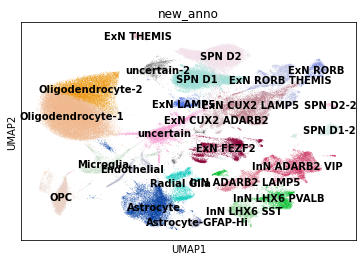

In [9]:
sc.pl.umap(adata, color=['new_anno'], legend_loc='on data')

#### find genes that have low cell counts

In [10]:
display(adata.var['n_cells'].describe())
# floor_cnt = adata.var['n_cells'].describe()['25%']
print(np.percentile(adata.var['n_cells'], np.arange(5, 100, 5)))
print(np.percentile(adata.var['n_cells'], np.arange(25, 100, 25)))
floor_cnt = np.percentile(adata.var['n_cells'], np.arange(10, 100, 10))[0]
print(floor_cnt)

count     35441.000000
mean      16469.642025
std       27565.779047
min           1.000000
25%         231.000000
50%        2686.000000
75%       20259.000000
max      167938.000000
Name: n_cells, dtype: float64

[8.0000e+00 2.9000e+01 6.6000e+01 1.2900e+02 2.3100e+02 3.9000e+02
 6.4000e+02 1.0500e+03 1.6990e+03 2.6860e+03 4.2470e+03 6.5030e+03
 9.5720e+03 1.4113e+04 2.0259e+04 2.8518e+04 4.0044e+04 5.6432e+04
 8.1147e+04]
[  231.  2686. 20259.]
29.0


In [11]:
# print(adata.var.shape)
# print(adata.var.loc[adata.var['n_cells'] < 6].head())
genes_with_low_cell_counts = adata.var.loc[adata.var['n_cells'] < floor_cnt].index.to_list()
print(len(genes_with_low_cell_counts))
# genes_with_low_cell_counts

3518


In [12]:
adata.var['hvf_rank'].describe()

count    35441.000000
mean     24687.253717
std      18400.378200
min         -1.000000
25%       7559.000000
50%      23323.000000
75%      42120.000000
max      59156.000000
Name: hvf_rank, dtype: float64

In [13]:
print(adata.obs.groupby(['Brain_region','Age_group'])['Sample_id'].nunique())

Brain_region           Age_group
Entorhinal cortex      old          6
                       young        6
Middle temporal gyrus  old          7
                       young        5
Putamen                old          7
                       young        5
Subventricular zone    old          6
                       young        6
Name: Sample_id, dtype: int64


In [14]:
print(adata.obs.groupby(['new_anno','Age_group'])['Sample_id'].nunique())

new_anno           Age_group
Astrocyte          old          26
                   young        22
Astrocyte-GFAP-Hi  old           0
                   young         1
Endothelial        old          26
                   young        22
ExN CUX2 ADARB2    old           8
                   young         8
ExN CUX2 LAMP5     old          24
                   young        20
ExN FEZF2          old          15
                   young        13
ExN LAMP5          old           7
                   young         6
ExN RORB           old           8
                   young         8
ExN RORB THEMIS    old          14
                   young        12
ExN THEMIS         old           9
                   young         6
InN ADARB2 LAMP5   old          26
                   young        22
InN ADARB2 VIP     old          26
                   young        21
InN LHX6 PVALB     old          25
                   young        20
InN LHX6 SST       old          24
                   young  

### read the brain region diff by age results

In [15]:
%%time
regions_df = pd.read_csv(region_results)
# drop the empty results
regions_df = regions_df.loc[(~regions_df['p-value'].isna()) & 
                            (~regions_df['log2_fc'].isna())]
print(regions_df.shape)
display(regions_df.head())
print(regions_df['group'].value_counts())

(129510, 9)


,Unnamed: 0,feature,intercept,coef,stderr,z,p-value,log2_fc,group
0,0,STS,1.262513,0.119976,0.237154,0.505897,0.612929,0.130969,Middle temporal gyrus
1,1,AC108142.1,0.000654,-0.000569,0.000408,-1.393651,0.163423,-2.937948,Middle temporal gyrus
2,2,NXN,0.328693,-0.005688,0.060325,-0.094295,0.924875,-0.025186,Middle temporal gyrus
3,3,AC090812.1,0.000324,0.000104,0.000333,0.312497,0.754663,0.401328,Middle temporal gyrus
4,4,AL357093.2,0.053173,0.002485,0.010516,0.236332,0.813175,0.065904,Middle temporal gyrus


Entorhinal cortex        33928
Middle temporal gyrus    32962
Putamen                  32248
Subventricular zone      30372
Name: group, dtype: int64
CPU times: user 154 ms, sys: 7.13 ms, total: 161 ms
Wall time: 159 ms


#### computer B&H FDR for genes different by age in the brain regions

In [16]:
regions_df = compute_bh_fdr(regions_df)
print(regions_df.shape)
display(regions_df.head())

total significant after correction: (29, 10)
(129510, 10)


,Unnamed: 0,feature,intercept,coef,stderr,z,p-value,log2_fc,group,fdr_bh
0,0,STS,1.262513,0.119976,0.237154,0.505897,0.612929,0.130969,Middle temporal gyrus,1.0
1,1,AC108142.1,0.000654,-0.000569,0.000408,-1.393651,0.163423,-2.937948,Middle temporal gyrus,1.0
2,2,NXN,0.328693,-0.005688,0.060325,-0.094295,0.924875,-0.025186,Middle temporal gyrus,1.0
3,3,AC090812.1,0.000324,0.000104,0.000333,0.312497,0.754663,0.401328,Middle temporal gyrus,1.0
4,4,AL357093.2,0.053173,0.002485,0.010516,0.236332,0.813175,0.065904,Middle temporal gyrus,1.0


In [17]:
regions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129510 entries, 0 to 134144
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  129510 non-null  int64  
 1   feature     129510 non-null  object 
 2   intercept   129510 non-null  float64
 3   coef        129510 non-null  float64
 4   stderr      129510 non-null  float64
 5   z           129510 non-null  float64
 6   p-value     129510 non-null  float64
 7   log2_fc     129510 non-null  float64
 8   group       129510 non-null  object 
 9   fdr_bh      129510 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 10.9+ MB


#### count of significant genes by brain region

In [18]:
regions_df.loc[regions_df['fdr_bh'] < 0.05]['group'].value_counts()

Middle temporal gyrus    15
Putamen                  12
Entorhinal cortex         2
Name: group, dtype: int64

#### save the statistically significant results

In [19]:
regions_df.loc[regions_df['fdr_bh'] < 0.05].to_csv(regions_out, index=False)

In [20]:
regions_df.loc[regions_df['fdr_bh'] < 0.05].head()

,Unnamed: 0,feature,intercept,coef,stderr,z,p-value,log2_fc,group,fdr_bh
894,894,AC007608.3,0.020347,-0.011097,0.002308,-4.808529,0.000002,-1.137232,Middle temporal gyrus,0.013128
7518,7518,AC093766.1,0.017529,-0.010823,0.002442,-4.432204,0.000009,-1.386245,Middle temporal gyrus,0.045988
7823,7823,LINC01513,0.005708,0.008590,0.001941,4.426273,0.000010,1.324712,Middle temporal gyrus,0.045988
8225,8225,CDKN2A,0.050429,0.037005,0.008012,4.618627,0.000004,0.793943,Middle temporal gyrus,0.023823
8737,8737,LRMDA,0.596248,0.291181,0.060773,4.791256,0.000002,0.573719,Middle temporal gyrus,0.013416


#### how many of these have low cell counts

In [21]:
len(set(genes_with_low_cell_counts) & 
    set(regions_df.loc[regions_df['fdr_bh'] < 0.05]['feature']))

1

#### count of significant genes by brain region with greater than 1/2 fold change

In [22]:
regions_df.loc[(regions_df['fdr_bh'] < 0.05) & 
               (abs(regions_df['log2_fc']) > 0.5)]['group'].value_counts()

Middle temporal gyrus    14
Putamen                  10
Entorhinal cortex         2
Name: group, dtype: int64

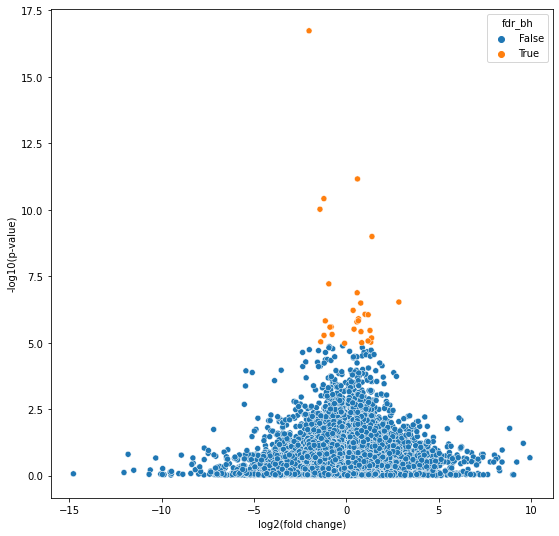

Middle temporal gyrus


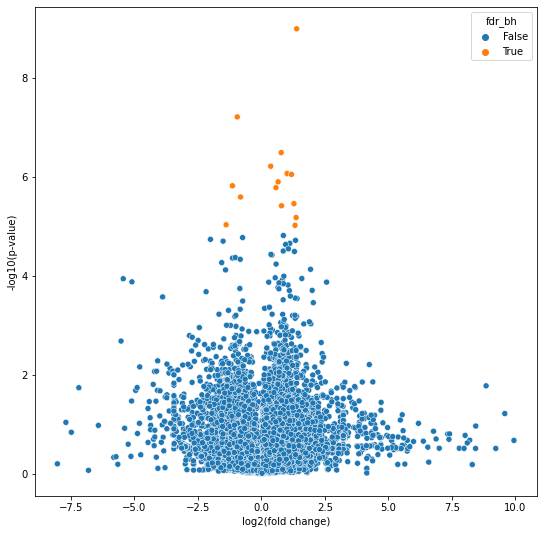

Putamen


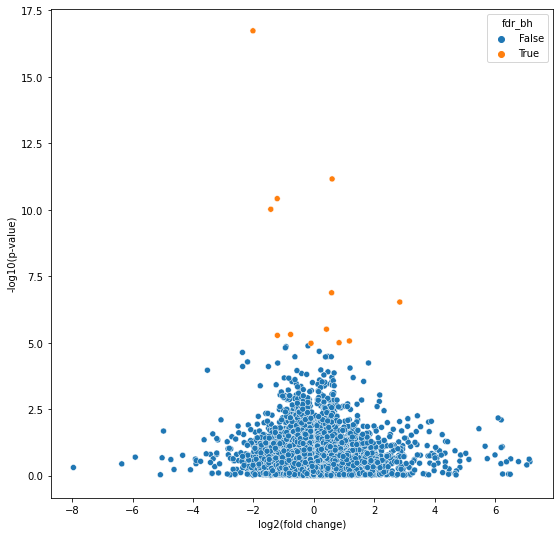

Entorhinal cortex


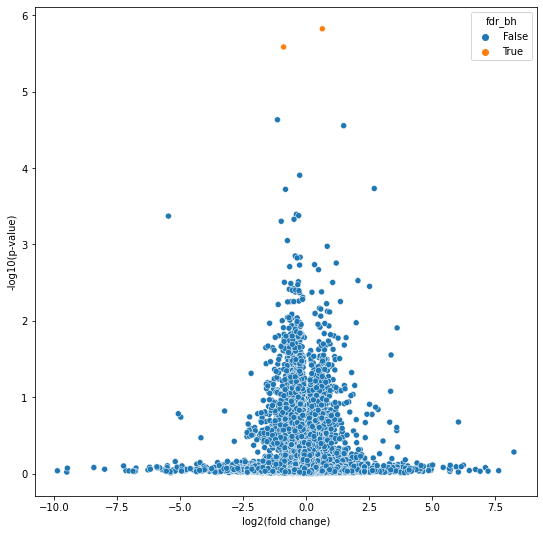

Subventricular zone


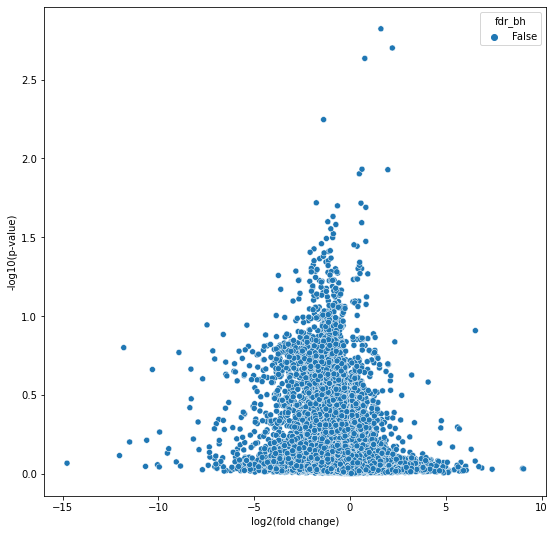

In [23]:
volcano_plot(regions_df)

for region in regions_df['group'].unique():
    print(region)
    volcano_plot(regions_df.loc[regions_df['group'] == region])

#### look at some of the individual results

Unnamed: 0         21116
feature       AC109460.4
intercept       0.001358
coef           -0.001022
stderr           0.00012
z              -8.501692
p-value              0.0
log2_fc        -2.016704
group            Putamen
fdr_bh               0.0
Name: 54616, dtype: object


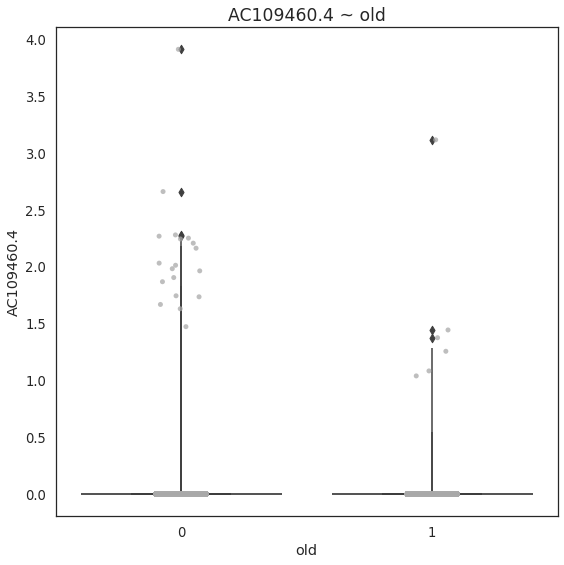

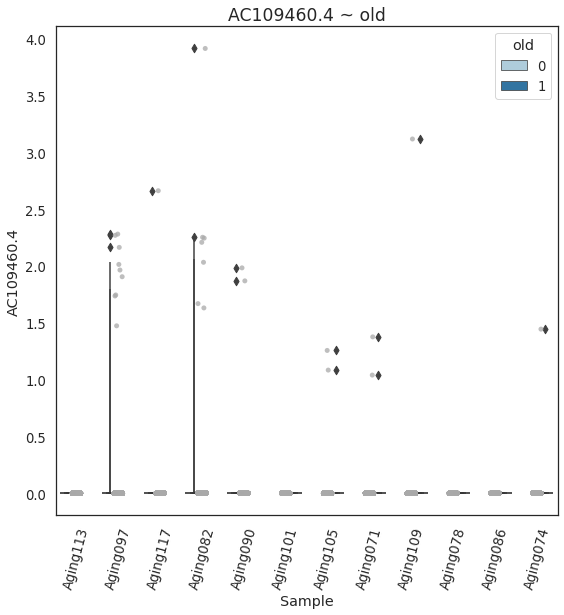

In [24]:
# max significant by p-value
this_results = regions_df.loc[regions_df['p-value'] == min(regions_df['p-value'])]
this_hit = this_results.sort_values(by=['coef'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit)

In [25]:
'AC108868.1' in genes_with_low_cell_counts

False

Unnamed: 0                    19056
feature                      RHBDL3
intercept                   0.35052
coef                       0.567005
stderr                     0.092856
z                          6.106259
p-value                         0.0
log2_fc                    1.388251
group         Middle temporal gyrus
fdr_bh                     0.000026
Name: 19056, dtype: object


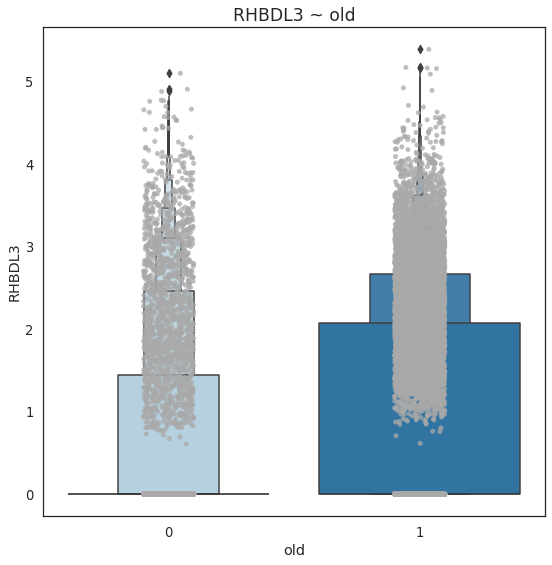

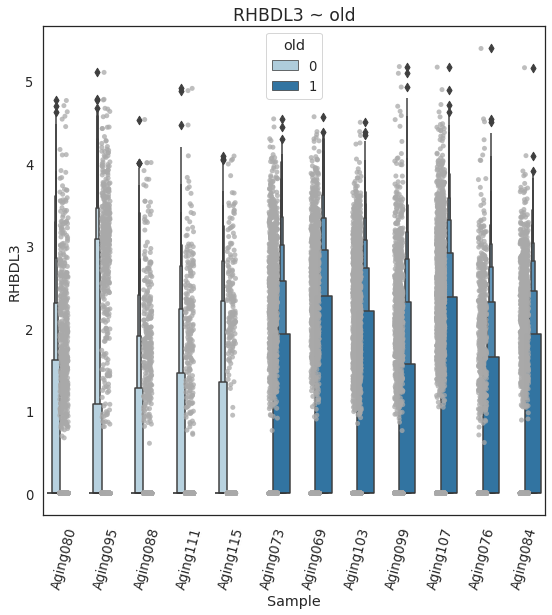

In [26]:
# max significant by coef
sig_results = regions_df.loc[regions_df['fdr_bh'] < 0.05]
this_results = sig_results.loc[sig_results['coef'] == max(sig_results['coef'])]
this_hit = this_results.sort_values(by=['log2_fc'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit)

In [27]:
'AL031598.1' in genes_with_low_cell_counts

False

Unnamed: 0       24195
feature         MCIDAS
intercept     0.001788
coef          0.011057
stderr        0.002157
z             5.125165
p-value            0.0
log2_fc       2.844625
group          Putamen
fdr_bh        0.004672
Name: 57695, dtype: object


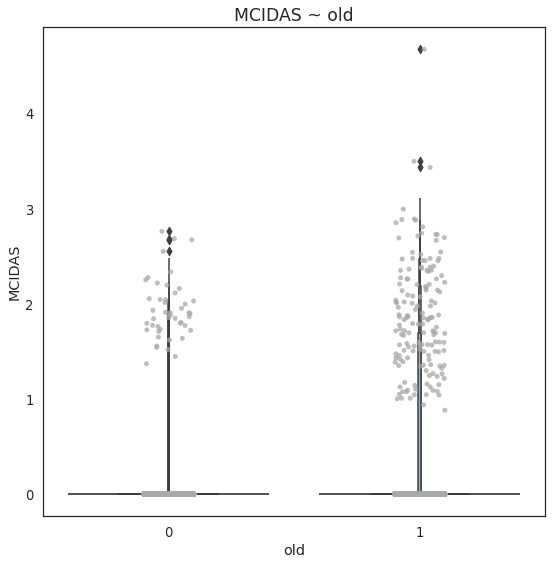

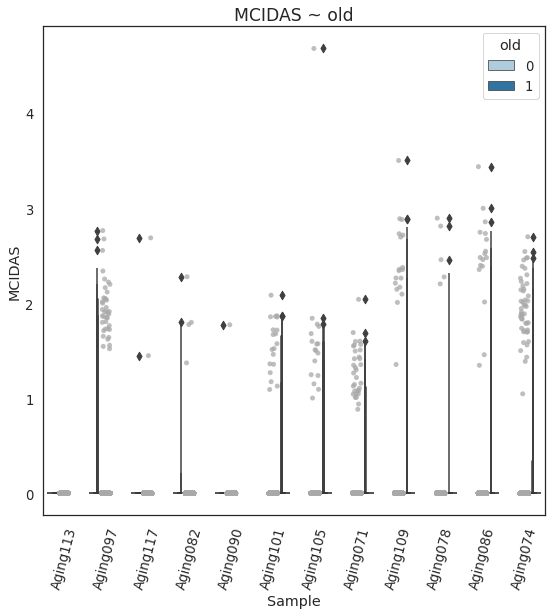

In [28]:
# random
this_hit = sig_results.sample().iloc[0]
prep_plot_feature(adata, this_hit)

Unnamed: 0                   8407
feature                AL033523.1
intercept                1.994276
coef                     1.044223
stderr                   0.532957
z                        1.959301
p-value                  0.050078
log2_fc                  0.607494
group         Subventricular zone
fdr_bh                        1.0
Name: 109673, dtype: object


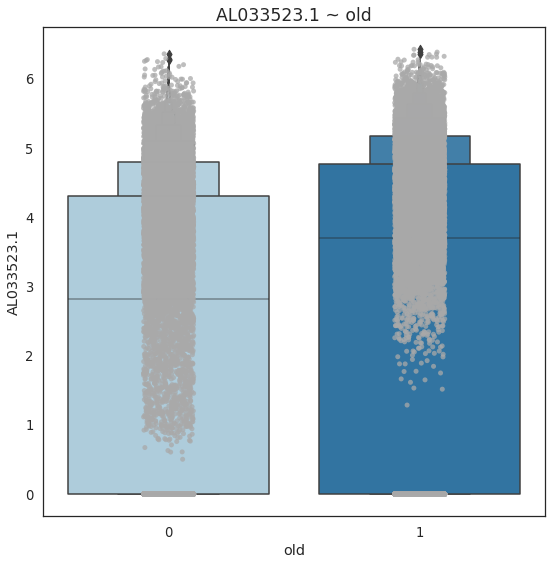

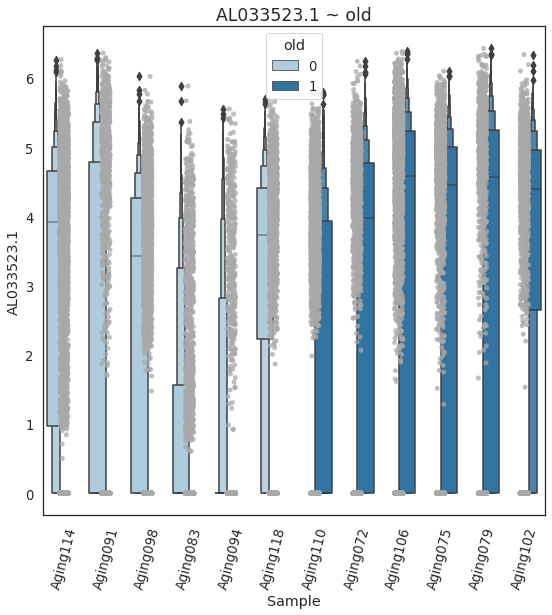

In [29]:
# max non-significat by coef
nonsig_results = regions_df.loc[regions_df['fdr_bh'] > 0.05]
this_results = nonsig_results.loc[nonsig_results['coef'] == max(nonsig_results['coef'])]
this_hit = this_results.sort_values(by=['log2_fc'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit)

Unnamed: 0                     6224
feature                       FAM9A
intercept                       0.0
coef                       0.000204
stderr                     0.000164
z                          1.242969
p-value                    0.213879
log2_fc                     9.93955
group         Middle temporal gyrus
fdr_bh                          1.0
Name: 6224, dtype: object


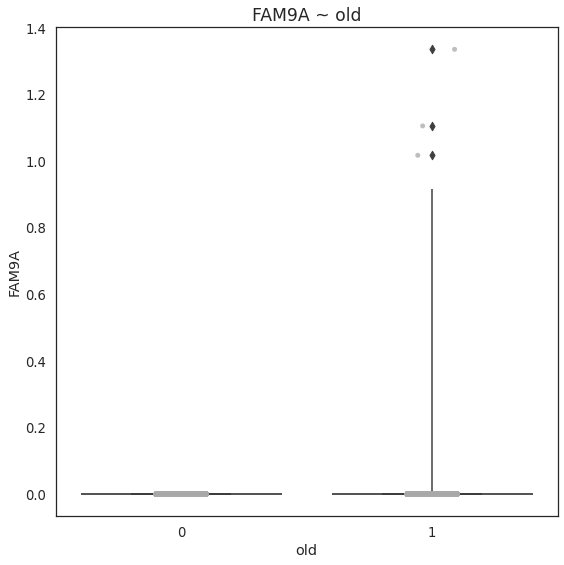

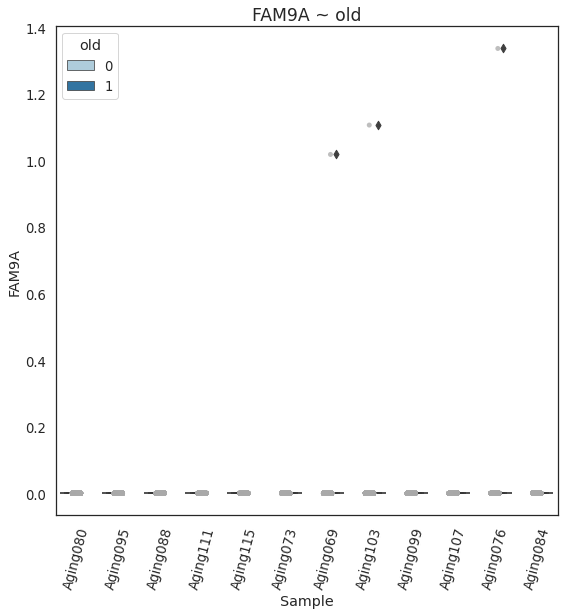

In [30]:
# max non-significat by fc
nonsig_results = regions_df.loc[regions_df['fdr_bh'] > 0.05]
this_results = nonsig_results.loc[nonsig_results['log2_fc'] == max(nonsig_results['log2_fc'])]
this_hit = this_results.sort_values(by=['coef'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit)

### read the cell diff by age results

In [31]:
%%time
cells_df = pd.read_csv(cell_results)
# drop the empty results
cells_df = cells_df.loc[(~cells_df['p-value'].isna()) & 
                            (~cells_df['log2_fc'].isna())]
print(cells_df.shape)
display(cells_df.head())
print(cells_df['group'].value_counts())

(546350, 9)


,Unnamed: 0,feature,intercept,coef,stderr,z,p-value,log2_fc,group
0,0,SYF2,0.290008,-0.009390,0.076075,-0.123424,0.901771,-0.047483,ExN CUX2 LAMP5
1,1,PALMD,1.491025,-0.435019,0.196178,-2.217468,0.026591,-0.497686,ExN CUX2 LAMP5
2,2,NAGLU,0.091979,0.008884,0.019384,0.458341,0.646708,0.133026,ExN CUX2 LAMP5
3,3,CARS-AS1,0.083580,-0.010851,0.017630,-0.615470,0.538244,-0.200628,ExN CUX2 LAMP5
4,4,TACC2,1.356597,-0.156886,0.137472,-1.141214,0.253781,-0.177305,ExN CUX2 LAMP5


ExN CUX2 LAMP5       30667
ExN RORB THEMIS      29359
ExN FEZF2            29346
Oligodendrocyte-1    29139
InN ADARB2 VIP       29114
InN LHX6 PVALB       27185
Oligodendrocyte-2    26664
uncertain-2          25667
Astrocyte            25131
OPC                  24700
InN ADARB2 LAMP5     24085
InN LHX6 SST         23723
uncertain            22998
SPN D1-2             22770
ExN RORB             22603
Endothelial          20360
SPN D2-2             19631
SPN D1               19407
SPN D2               19221
Microglia            19085
ExN THEMIS           17779
Radial Glia          15535
ExN LAMP5            13470
ExN CUX2 ADARB2       8711
Name: group, dtype: int64
CPU times: user 686 ms, sys: 34.1 ms, total: 720 ms
Wall time: 718 ms


#### computer B&H FDR for genes different by age in the brain regions

In [32]:
cells_df = compute_bh_fdr(cells_df)
print(cells_df.shape)
display(cells_df.head())

total significant after correction: (2946, 10)
(546350, 10)


,Unnamed: 0,feature,intercept,coef,stderr,z,p-value,log2_fc,group,fdr_bh
0,0,SYF2,0.290008,-0.009390,0.076075,-0.123424,0.901771,-0.047483,ExN CUX2 LAMP5,1.000000
1,1,PALMD,1.491025,-0.435019,0.196178,-2.217468,0.026591,-0.497686,ExN CUX2 LAMP5,0.768885
2,2,NAGLU,0.091979,0.008884,0.019384,0.458341,0.646708,0.133026,ExN CUX2 LAMP5,1.000000
3,3,CARS-AS1,0.083580,-0.010851,0.017630,-0.615470,0.538244,-0.200628,ExN CUX2 LAMP5,1.000000
4,4,TACC2,1.356597,-0.156886,0.137472,-1.141214,0.253781,-0.177305,ExN CUX2 LAMP5,1.000000


In [33]:
cells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546350 entries, 0 to 699565
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  546350 non-null  int64  
 1   feature     546350 non-null  object 
 2   intercept   546350 non-null  float64
 3   coef        546350 non-null  float64
 4   stderr      546350 non-null  float64
 5   z           546350 non-null  float64
 6   p-value     546350 non-null  float64
 7   log2_fc     546350 non-null  float64
 8   group       546350 non-null  object 
 9   fdr_bh      546350 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 45.9+ MB


#### count of significant genes by brain region

In [34]:
cells_df.loc[cells_df['fdr_bh'] < 0.05]['group'].value_counts()

ExN LAMP5            1472
ExN RORB              204
InN LHX6 SST          187
ExN CUX2 LAMP5        142
InN LHX6 PVALB        133
OPC                   100
ExN THEMIS             83
ExN CUX2 ADARB2        82
InN ADARB2 LAMP5       75
Microglia              69
SPN D1                 55
ExN FEZF2              52
ExN RORB THEMIS        47
Oligodendrocyte-1      41
Astrocyte              39
SPN D2                 39
Radial Glia            21
SPN D2-2               21
Endothelial            18
Oligodendrocyte-2      18
uncertain-2            15
uncertain              12
SPN D1-2               12
InN ADARB2 VIP          9
Name: group, dtype: int64

#### save the statistically significant results

In [35]:
cells_df.loc[cells_df['fdr_bh'] < 0.05].to_csv(cells_out, index=False)

In [36]:
cells_df.loc[cells_df['fdr_bh'] < 0.05].head()

,Unnamed: 0,feature,intercept,coef,stderr,z,p-value,log2_fc,group,fdr_bh
130,130,HIP1,0.868435,-0.516208,0.082504,-6.256795,3.929706e-10,-1.301912,ExN CUX2 LAMP5,1.458556e-07
1528,1528,TEX43,0.017950,-0.010530,0.002851,-3.693121,2.215185e-04,-1.274516,ExN CUX2 LAMP5,4.263002e-02
1815,1815,SNCAIP,0.775252,-0.333756,0.084264,-3.960840,7.468655e-05,-0.812267,ExN CUX2 LAMP5,1.725370e-02
2093,2093,LINC01052,0.035170,-0.020422,0.004799,-4.255217,2.088466e-05,-1.253778,ExN CUX2 LAMP5,5.609801e-03
2256,2256,MAP3K6,0.014989,0.019884,0.005223,3.806983,1.406725e-04,1.218177,ExN CUX2 LAMP5,2.970871e-02


#### how many of these have low cell counts

In [37]:
len(set(genes_with_low_cell_counts) & 
    set(cells_df.loc[cells_df['fdr_bh'] < 0.05]['feature']))

0

#### count of significant genes by brain region with greater than 1/2 fold change

In [38]:
cells_df.loc[(cells_df['fdr_bh'] < 0.05) & 
             (abs(cells_df['log2_fc']) > 0.5)]['group'].value_counts()

ExN LAMP5            797
ExN RORB             169
ExN CUX2 LAMP5       116
InN LHX6 SST          87
InN LHX6 PVALB        67
ExN THEMIS            52
OPC                   47
InN ADARB2 LAMP5      46
Microglia             36
Astrocyte             27
ExN RORB THEMIS       25
ExN FEZF2             21
Oligodendrocyte-1     16
SPN D1                15
ExN CUX2 ADARB2       14
Endothelial           12
SPN D2                12
SPN D2-2              12
uncertain             11
Oligodendrocyte-2      9
uncertain-2            7
SPN D1-2               5
Radial Glia            5
InN ADARB2 VIP         4
Name: group, dtype: int64

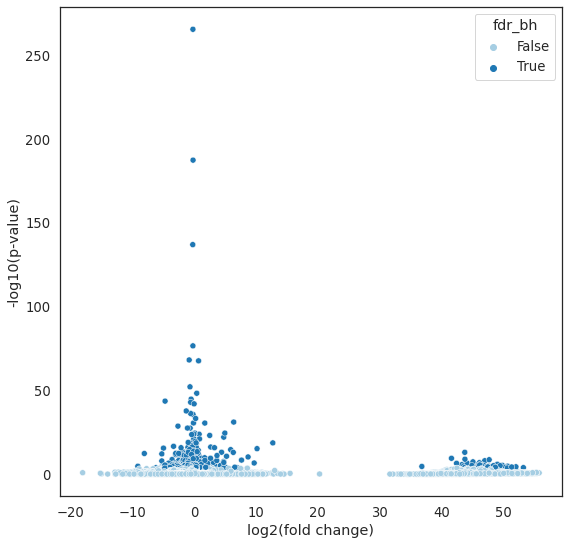

ExN CUX2 LAMP5


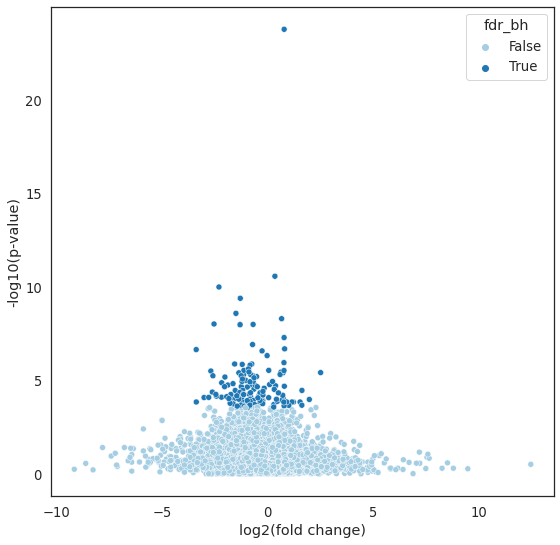

Oligodendrocyte-1


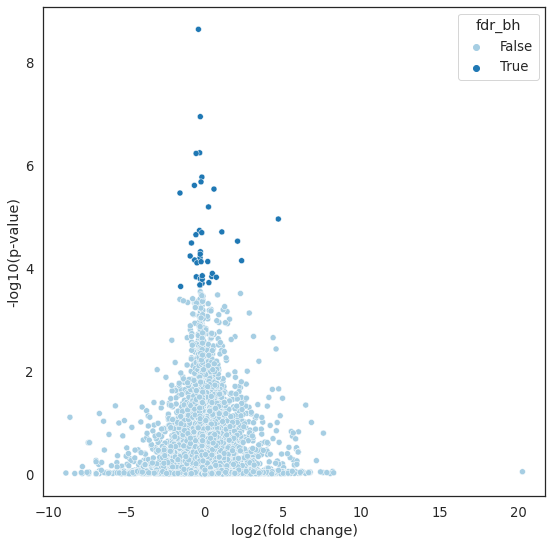

Astrocyte


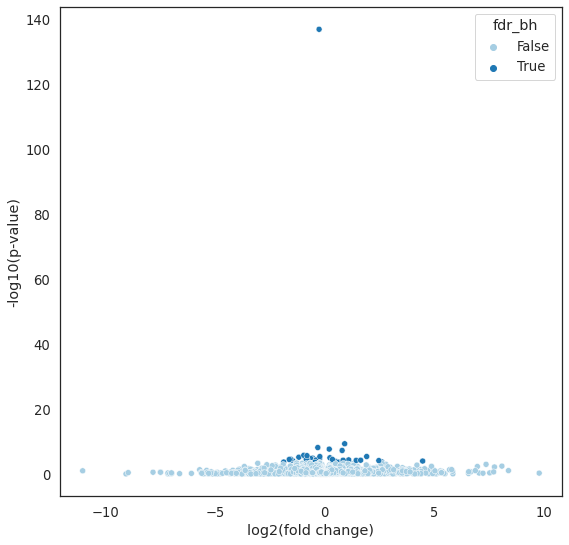

ExN RORB


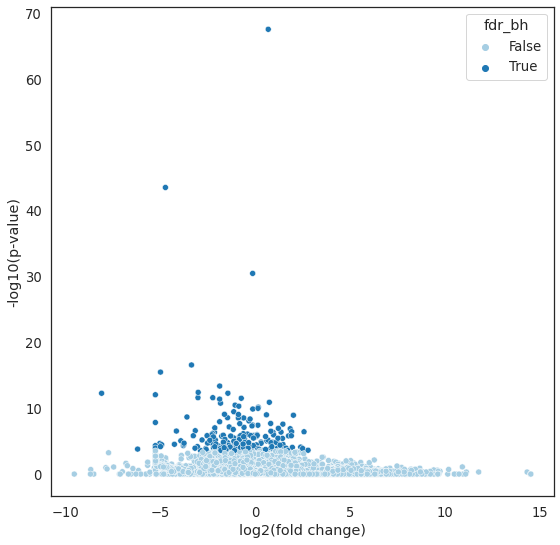

ExN RORB THEMIS


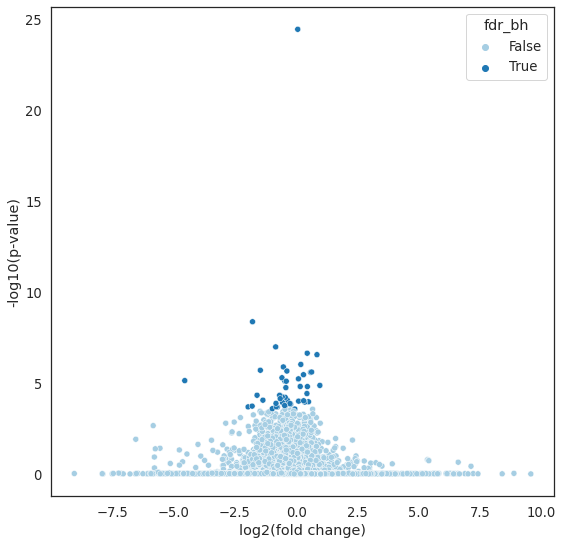

InN ADARB2 LAMP5


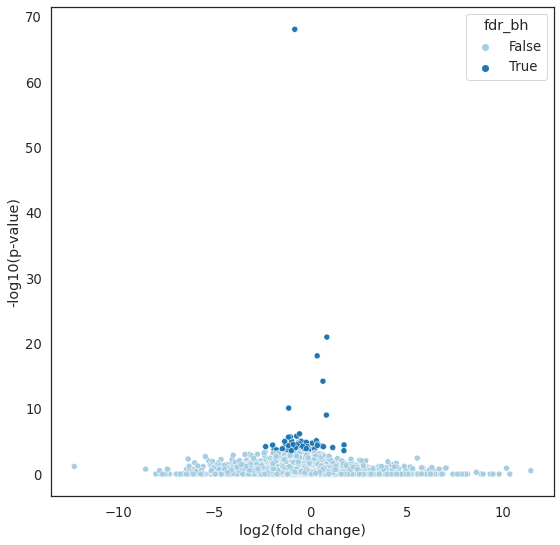

InN LHX6 SST


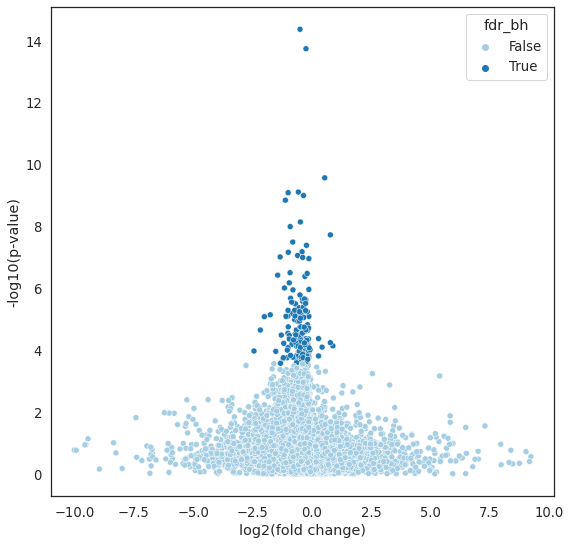

Oligodendrocyte-2


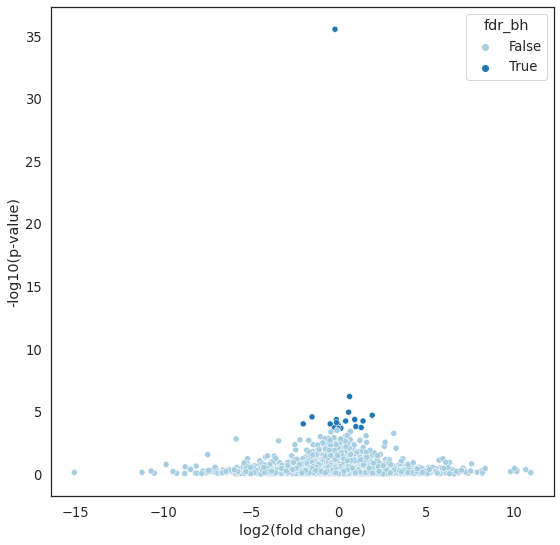

uncertain


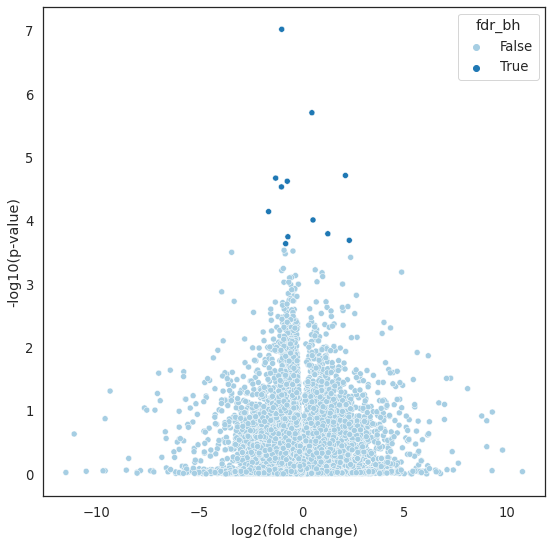

InN ADARB2 VIP


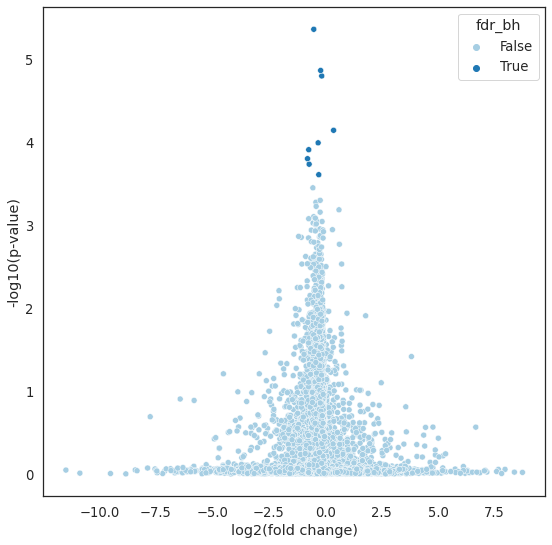

InN LHX6 PVALB


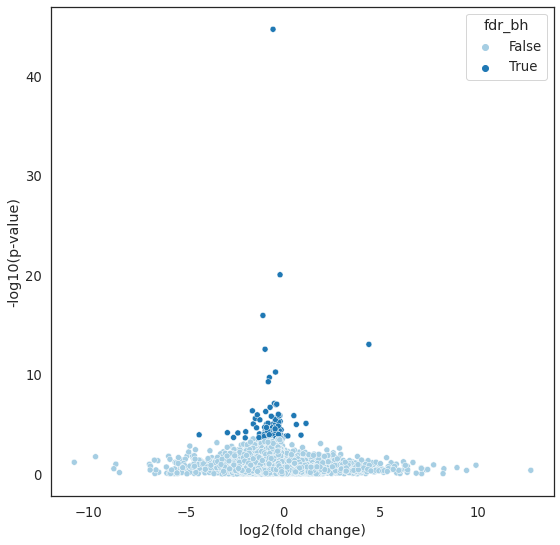

ExN FEZF2


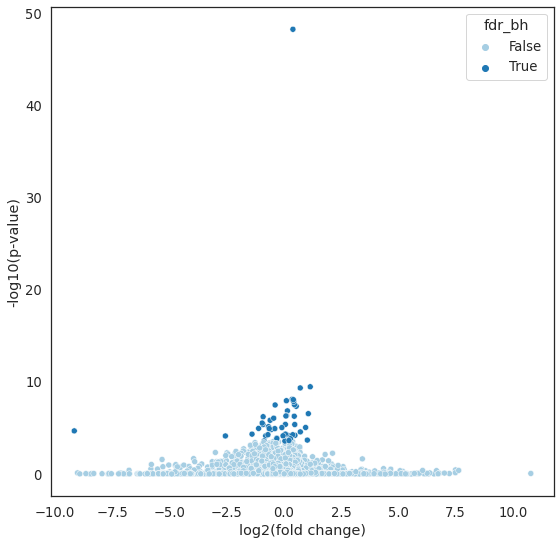

uncertain-2


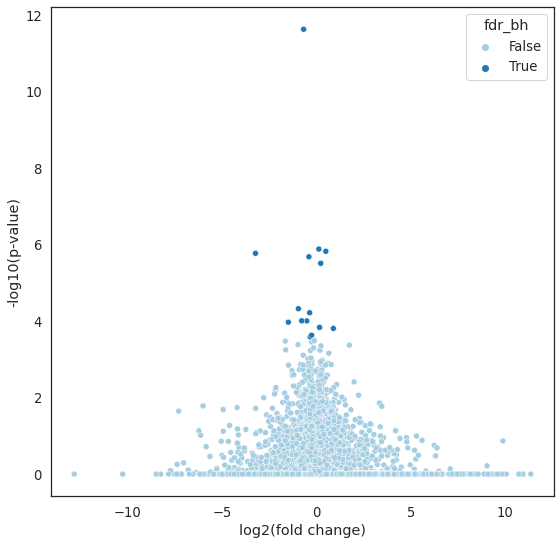

OPC


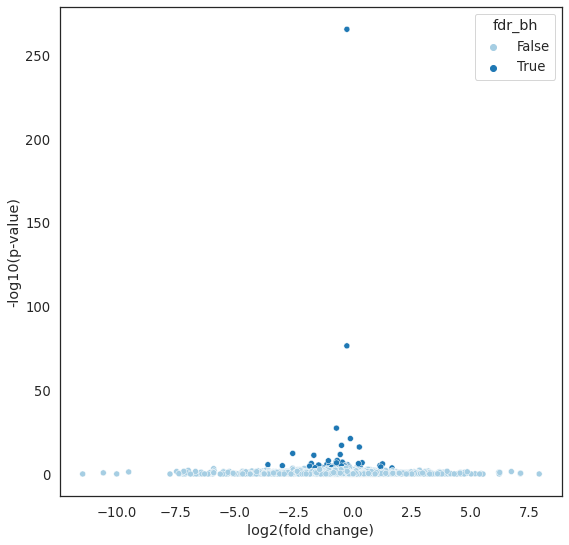

ExN THEMIS


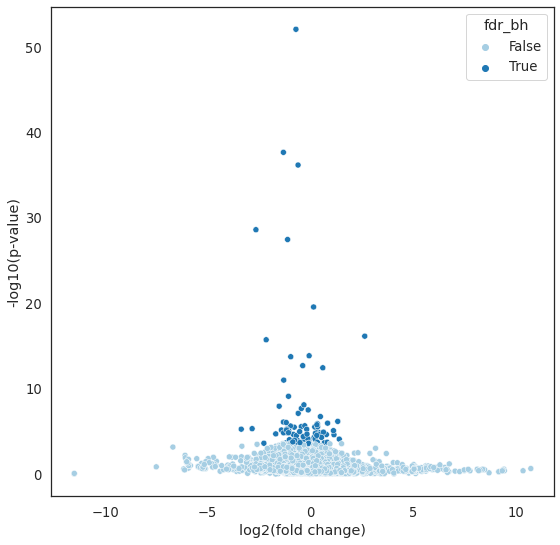

ExN CUX2 ADARB2


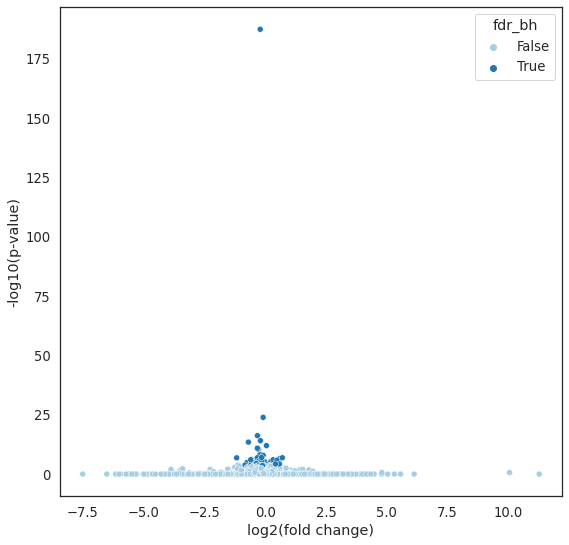

Endothelial


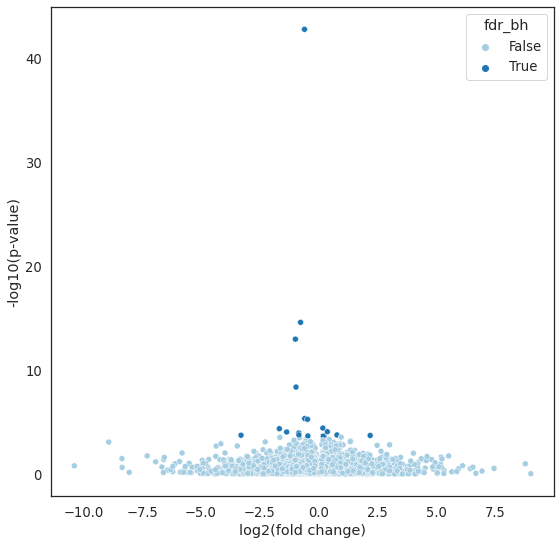

Microglia


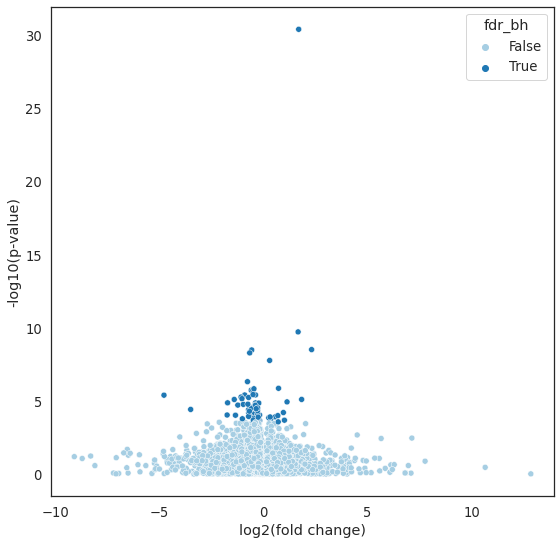

SPN D1-2


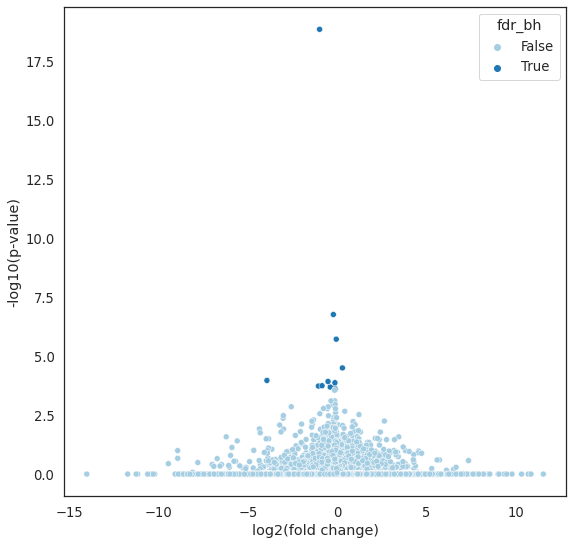

SPN D1


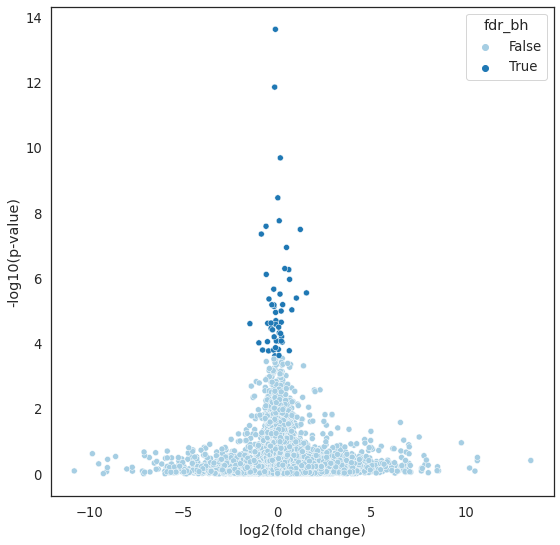

SPN D2


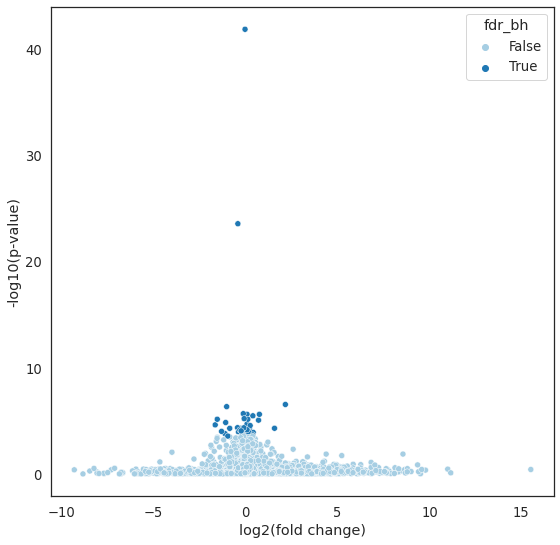

Radial Glia


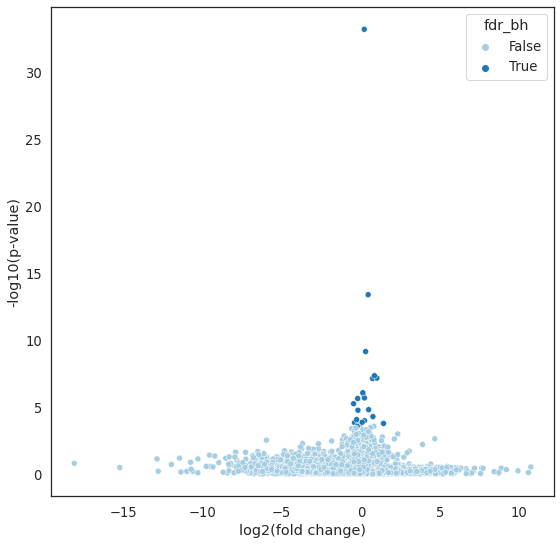

SPN D2-2


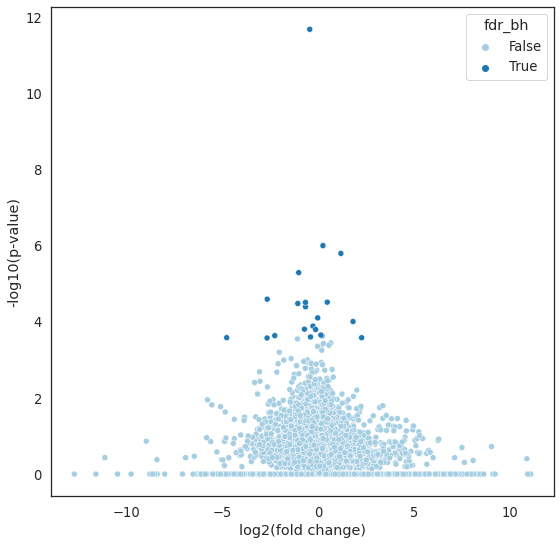

ExN LAMP5


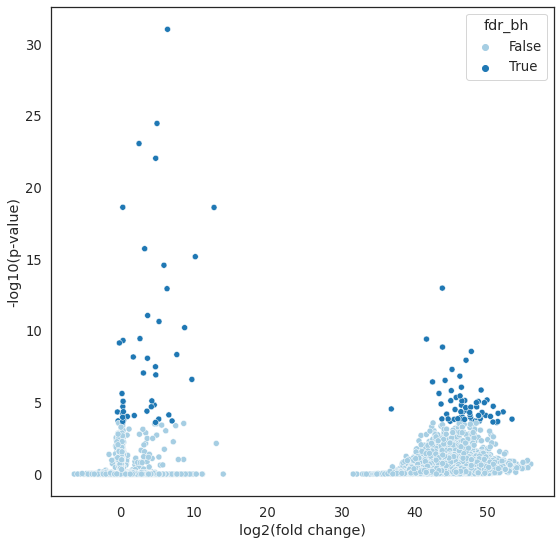

In [39]:
volcano_plot(cells_df)

for cell in cells_df['group'].unique():
    print(cell)
    volcano_plot(cells_df.loc[cells_df['group'] == cell])

#### look at some of the individual results

In [40]:
this_hit

Unnamed: 0                     6224
feature                       FAM9A
intercept                       0.0
coef                       0.000204
stderr                     0.000164
z                          1.242969
p-value                    0.213879
log2_fc                     9.93955
group         Middle temporal gyrus
fdr_bh                          1.0
Name: 6224, dtype: object

Unnamed: 0         2636
feature           SAMD3
intercept      0.054672
coef           2.349132
stderr             -0.0
z                  -inf
p-value             0.0
log2_fc         5.45838
group         ExN LAMP5
fdr_bh              0.0
Name: 675087, dtype: object


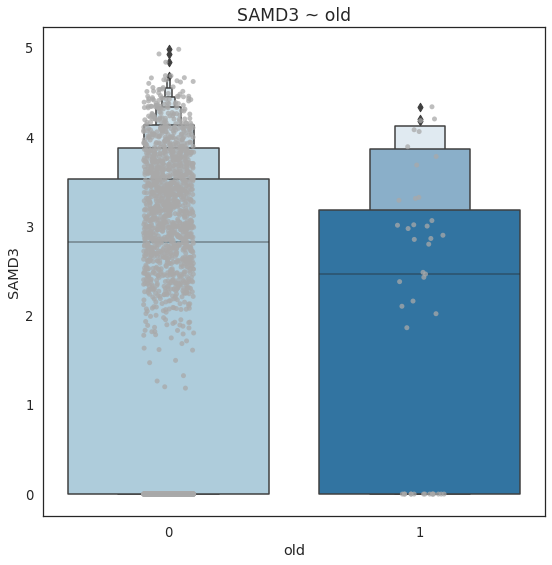

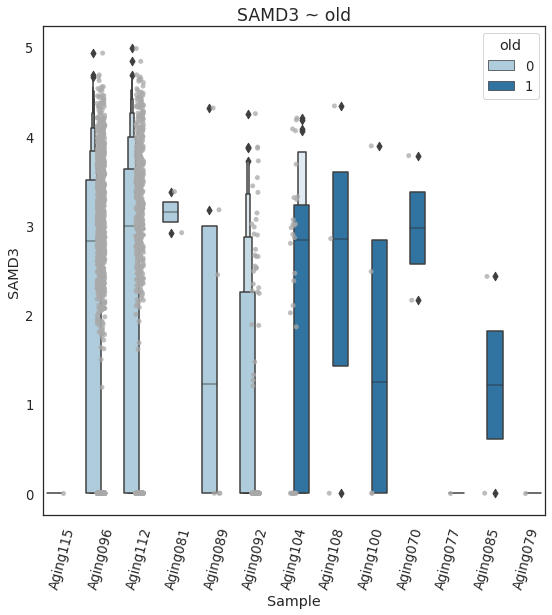

In [41]:
# max significant by p-value
this_results = cells_df.loc[cells_df['p-value'] == min(cells_df['p-value'])]
this_hit = this_results.sort_values(by=['coef'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit, type_name='new_anno')

Unnamed: 0         2636
feature           SAMD3
intercept      0.054672
coef           2.349132
stderr             -0.0
z                  -inf
p-value             0.0
log2_fc         5.45838
group         ExN LAMP5
fdr_bh              0.0
Name: 675087, dtype: object


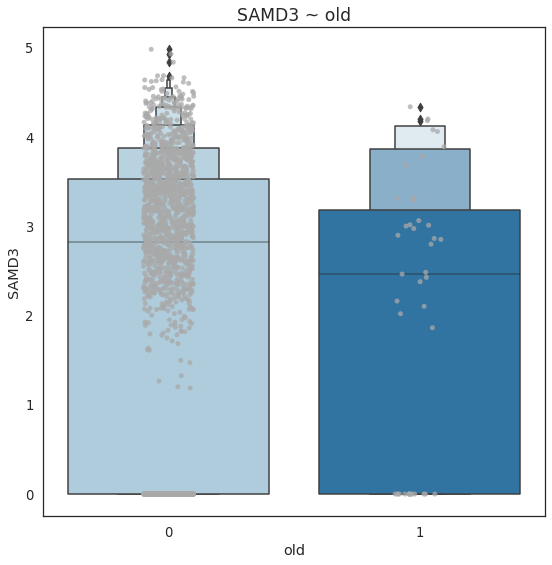

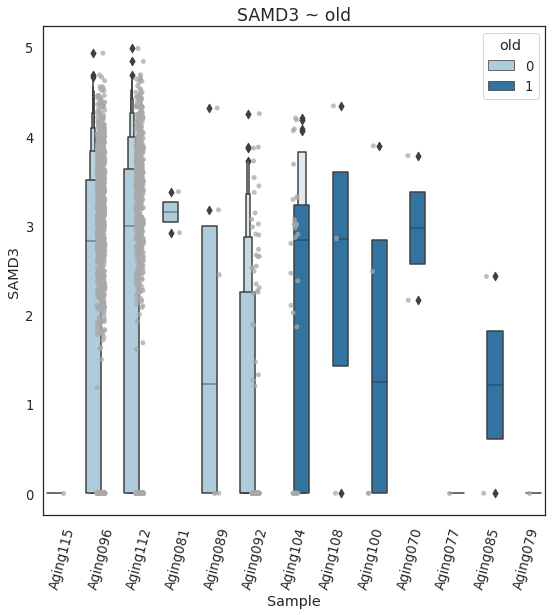

In [42]:
# max significant by coef
sig_results = cells_df.loc[cells_df['fdr_bh'] < 0.05]
this_results = sig_results.loc[sig_results['coef'] == max(sig_results['coef'])]
this_hit = this_results.sort_values(by=['log2_fc'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit, type_name='new_anno')

Unnamed: 0          547
feature       LIMD1-AS1
intercept     -0.001233
coef          -0.004637
stderr             -0.0
z                   inf
p-value             0.0
log2_fc        2.250795
group         ExN LAMP5
fdr_bh              0.0
Name: 672998, dtype: object


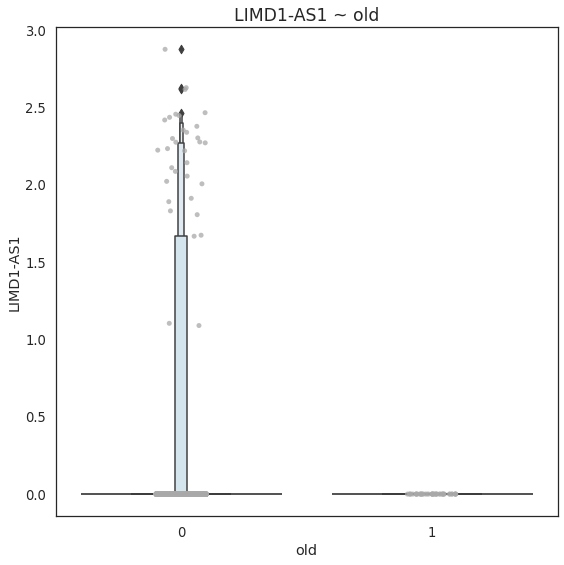

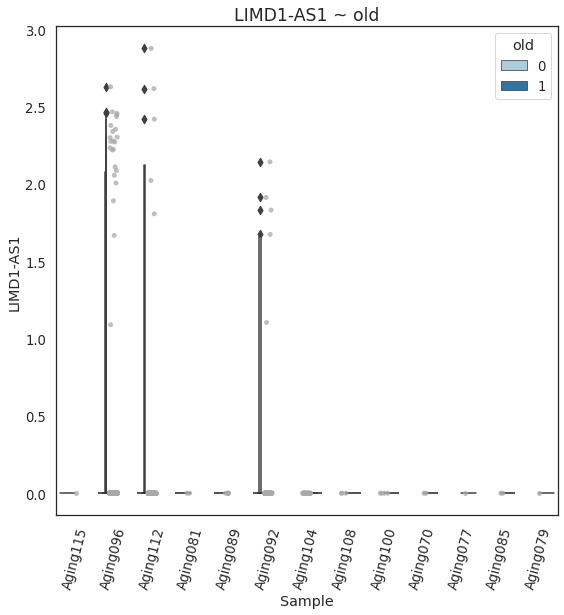

In [43]:
# random
this_hit = sig_results.sample().iloc[0]
prep_plot_feature(adata, this_hit, type_name='new_anno')

Unnamed: 0               7572
feature                CFAP44
intercept            0.330566
coef                 4.268448
stderr        23647886.588681
z                         0.0
p-value                   1.0
log2_fc              3.798313
group               ExN LAMP5
fdr_bh                    1.0
Name: 680023, dtype: object


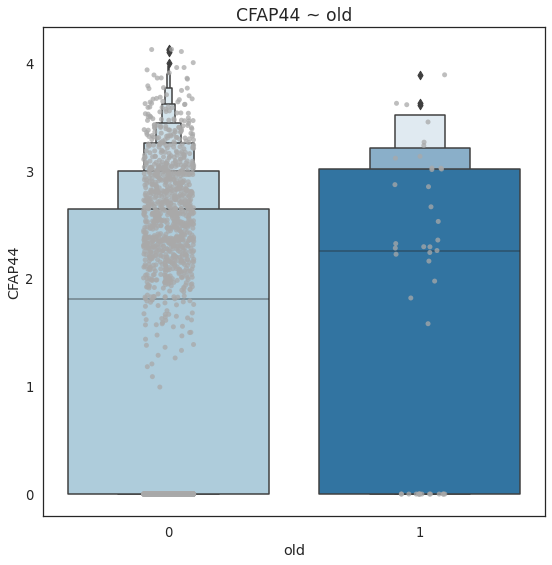

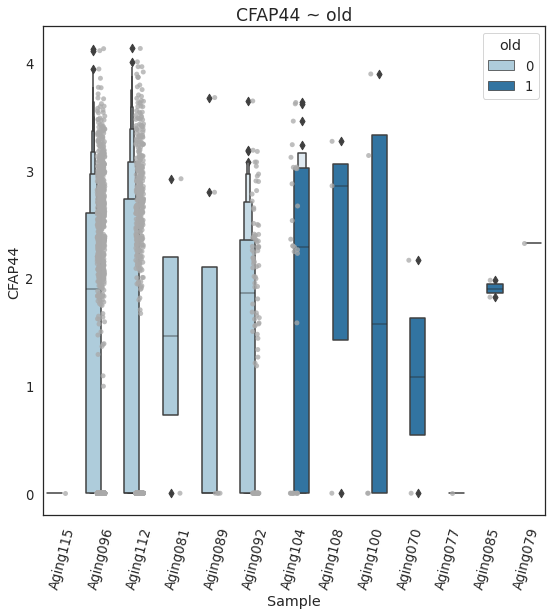

In [44]:
# max non-significat by coef
nonsig_results = cells_df.loc[cells_df['fdr_bh'] > 0.05]
this_results = nonsig_results.loc[nonsig_results['coef'] == max(nonsig_results['coef'])]
this_hit = this_results.sort_values(by=['log2_fc'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit, type_name='new_anno')

Unnamed: 0        15246
feature           ADCY7
intercept           0.0
coef          -0.560966
stderr         0.445361
z             -1.259574
p-value        0.207823
log2_fc             inf
group         ExN LAMP5
fdr_bh              1.0
Name: 687697, dtype: object


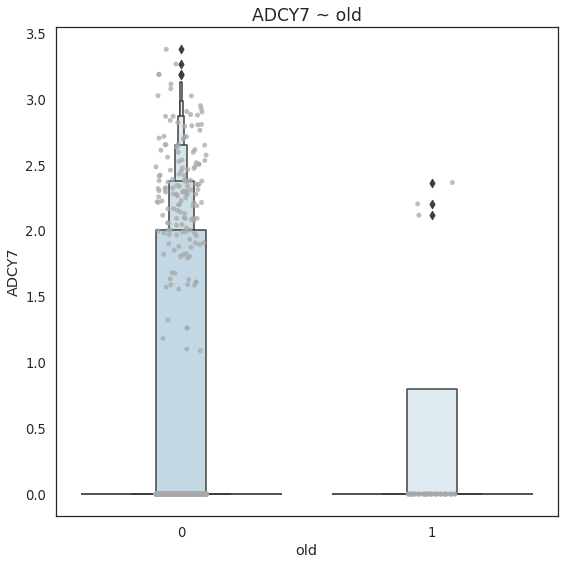

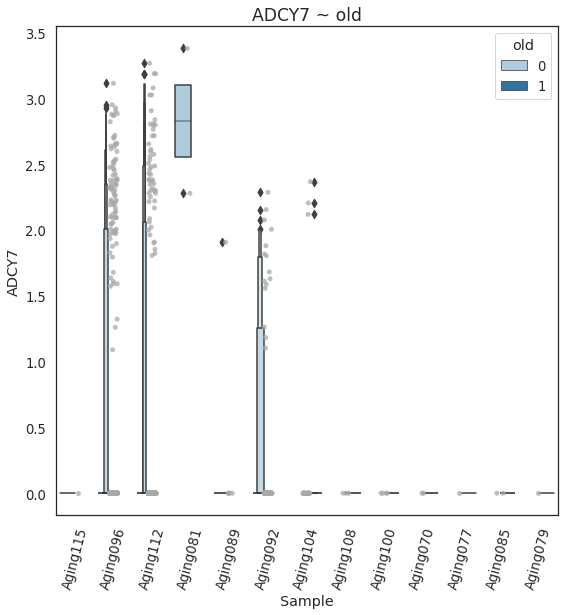

In [45]:
# max non-significat by fc
nonsig_results = cells_df.loc[cells_df['fdr_bh'] > 0.05]
this_results = nonsig_results.loc[nonsig_results['log2_fc'] == max(nonsig_results['log2_fc'])]
this_hit = this_results.sort_values(by=['coef'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit, type_name='new_anno')